# Cumulative Deaths Logistic Function Model (for highly impacted counties)
### Utilizes nyt_us_counties_cumulative.csv in the /data/us/covid/ directory for cumulative deaths data.
### (An auxilary) model is used for lowly impacted counties.

In [11]:
import numpy as np
import pandas as pd
import git
import matplotlib.pyplot as plt
repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir

## Read in data file and process

In [12]:
cum_deaths_df = pd.read_csv(f"{homedir}/data/us/covid/nyt_us_counties.csv", converters={'fips' : str, 'date' : str})
print(cum_deaths_df.dtypes)
print('W/ Converters -> fips : ' + str(type(cum_deaths_df['fips'][0])) + ', date : ' + str(type(cum_deaths_df['date'][0])))

# We specify the data type of fips and date as str using a converter for preprocessing convenience's sake.

date      object
county    object
state     object
fips      object
cases      int64
deaths     int64
dtype: object
W/ Converters -> fips : <class 'str'>, date : <class 'str'>


### Note that this NYT dataset lists elements by unique date, county/fips pairs.

In [13]:
print('NYT dataset:')
print(cum_deaths_df.head())

NYT dataset:
         date     county       state   fips  cases  deaths
0  2020-01-21  Snohomish  Washington  53061      1       0
1  2020-01-22  Snohomish  Washington  53061      1       0
2  2020-01-23  Snohomish  Washington  53061      1       0
3  2020-01-24       Cook    Illinois  17031      1       0
4  2020-01-24  Snohomish  Washington  53061      1       0


### Here is the number of counties in our dataset prior to adjusting for multi-county regions included as single entries in the dataset. 

In [14]:
print(str(len(set(list(cum_deaths_df['fips']))) - 1) + " counties total (without correcting for aggregation)")

# We subtract 1 here because this dataset includes a minority of data entries that do not have an exact fips code. These are 
# assigned a common FIPS code of 0 and correspond to the aforementioned multi-county regions.

2832 counties total (without correcting for aggregation)


### Now we'll construct an additional column called "day_rank" which will hold the number of days from some reference past date (reference date will be the same for all entries) to the entry's date. This will be used later to construct data compatible for fitting.

In [15]:
from datetime import date
from datetime import timedelta # to be used later for building a submission file

# Returns a 3-tuple of the year, month, and day of the date "ds". Assumes ds is a string in form "year-month-day"
def date_from_str(ds):
    year = int(ds[:4])
    month = int(ds[5:7])
    day = int(ds[8:])
    return (year, month, day)

dates = np.array(cum_deaths_df['date'])
day_rank = []
date_benchmark = date(2018, 1, 1) # some arbitrary date long before COVID-19 was around

# compute all dates' day ranks
for i in range(len(dates)):
    year, month, day = date_from_str(dates[i])
    date_cur = date(year, month, day)
    day_rank.append((date_cur - date_benchmark).days)

cum_deaths_df['day_rank'] = np.array(day_rank)
cum_deaths_df.head()

,date,county,state,fips,cases,deaths,day_rank
0,2020-01-21,Snohomish,Washington,53061,1,0,750
1,2020-01-22,Snohomish,Washington,53061,1,0,751
2,2020-01-23,Snohomish,Washington,53061,1,0,752
3,2020-01-24,Cook,Illinois,17031,1,0,753
4,2020-01-24,Snohomish,Washington,53061,1,0,753


### Let's check if any of the fips are invalid or missing.

In [16]:
all_clear = True
fips = list(cum_deaths_df['fips'])
for fip in fips:
    if ((not any([char.isdigit()] for char in fip)) or fip == ""):
        all_clear = False
        print('NaN or missing fips found. FIPS: ' + str(fip))
        
if all_clear: print('All fips are valid; none are invalid or missing.')

NaN or missing fips found. FIPS: 
NaN or missing fips found. FIPS: 
NaN or missing fips found. FIPS: 
NaN or missing fips found. FIPS: 
NaN or missing fips found. FIPS: 
NaN or missing fips found. FIPS: 
NaN or missing fips found. FIPS: 
NaN or missing fips found. FIPS: 
NaN or missing fips found. FIPS: 
NaN or missing fips found. FIPS: 
NaN or missing fips found. FIPS: 
NaN or missing fips found. FIPS: 
NaN or missing fips found. FIPS: 
NaN or missing fips found. FIPS: 
NaN or missing fips found. FIPS: 
NaN or missing fips found. FIPS: 
NaN or missing fips found. FIPS: 
NaN or missing fips found. FIPS: 
NaN or missing fips found. FIPS: 
NaN or missing fips found. FIPS: 
NaN or missing fips found. FIPS: 
NaN or missing fips found. FIPS: 
NaN or missing fips found. FIPS: 
NaN or missing fips found. FIPS: 
NaN or missing fips found. FIPS: 
NaN or missing fips found. FIPS: 
NaN or missing fips found. FIPS: 
NaN or missing fips found. FIPS: 
NaN or missing fips found. FIPS: 
NaN or missing

### Let's look at some stats regarding the current distribution of cumulative deaths.

In [26]:
recent_deaths = list(cum_deaths_df[cum_deaths_df['date'] == '2020-04-28']['deaths'])

# Average cumulative deaths per county
print('Average: ' + str(sum(recent_deaths) / len(recent_deaths))[:2] + ' deaths')

# Standard deviation
print('Standard Deviation: ' + str(np.std(np.array(recent_deaths)))[:2] + ' deaths')

# Number of counties above deaths threshold
thresholds = [1, 5, 10, 20, 50, 100, 500, 1000, 5000]
for threshold in thresholds:
    count = 0
    for d in recent_deaths:
        if (d >= threshold):
            count += 1
    print(str(100 * count / len(recent_deaths))[:4] + "% of all counties have " + str(threshold) 
          + " or more cumulative deaths as of April 28th, 2020.")

# Max deaths county
idx_max = recent_deaths.index(max(recent_deaths))
print(str(cum_deaths_df['county'][idx_max]) + ' County (fips = ' + str(cum_deaths_df['fips'][idx_max]) + 
      ') has the maximum cumulative deaths, ' + str(max(recent_deaths)) + ' deaths')

Average: 18 deaths
Standard Deviation: 24 deaths
50.3% of all counties have 1 or more cumulative deaths as of April 28th, 2020.
21.9% of all counties have 5 or more cumulative deaths as of April 28th, 2020.
14.2% of all counties have 10 or more cumulative deaths as of April 28th, 2020.
8.55% of all counties have 20 or more cumulative deaths as of April 28th, 2020.
4.32% of all counties have 50 or more cumulative deaths as of April 28th, 2020.
2.67% of all counties have 100 or more cumulative deaths as of April 28th, 2020.
0.63% of all counties have 500 or more cumulative deaths as of April 28th, 2020.
0.31% of all counties have 1000 or more cumulative deaths as of April 28th, 2020.
0.03% of all counties have 5000 or more cumulative deaths as of April 28th, 2020.
Clay County (fips = 12019) has the maximum cumulative deaths, 12067 deaths


### We'll now construct data usable for fitting.

In [18]:
# class used to represent each county and its data required for modeling
class data_entry:
    def __init__(self, deaths=[], times=[]):
        self.deaths = deaths
        self.times = times

In [19]:
# map counties' fips to concatenated deaths and dates from our dataset's data entries
county_dict = {}
counties = np.array(cum_deaths_df['fips'])
deaths = np.array(cum_deaths_df['deaths'])
dates = np.array(cum_deaths_df['day_rank'])
unique_counties = set(counties)
for county in list(unique_counties):
    t = []
    d = []
    for i in range(len(deaths)):
        if counties[i] == county:
            t.append(dates[i])
            d.append(deaths[i])
    county_dict[county] = data_entry(deaths=d, times=t)

In [20]:
print(county_dict['53061'].deaths)
count = 0
for fips in counties:
    if fips == '53061':
        count += 1
print(count)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 3, 3, 3, 3, 4, 5, 6, 7, 9, 10, 10, 15, 15, 18, 23, 23, 23, 30, 32, 39, 39, 41, 44, 48, 57, 60, 61, 63, 66, 67, 69, 73, 77, 80, 85, 87, 92, 92, 96, 98, 98, 99, 102, 103, 104, 106, 106]
99


### We will now process and divide our mapping into four categories of severity with respect to selected cumulative death divisions based on April 20th, 2020.

In [21]:
# function to process and divide counties into usable data
def process_county(county, county_dict):
    # subsets of fit data for which we are constructing
    X_sub = []
    Y_sub = []
    
    # find first day where a death occured
    entry = county_dict[county]
    first_death = 0
    for i in range(len(entry.deaths)):
        if entry.deaths[i] == 1:
            first_death = i
            break
    
    # We map X_sub in this way in order to shift dates (in the form of day_rank values) so that first_death is rank 0
    X_sub = list(map(lambda x: x - entry.times[first_death], entry.times[first_death:]))
    Y_sub = list(entry.deaths[first_death:])
    return data_entry(Y_sub, X_sub)

# use process_county funtion to clean county_dict
counties = county_dict.keys()
for county in counties:
    county_dict[county] = process_county(county, county_dict)

# returns the division of the input deaths value
def find_div(d, divs):
    for i in range(len(divs) + 1):
        if i == 0:
            if 0 < d and d <= divs[i]:
                return 0
        if i != len(divs):
            if (divs[i - 1] < d and d <= divs[i]):
                return i
        if (i == len(divs) and d > divs[-1]):
            return i

In [22]:
# cumulative death divisions for categorizing each county
divisions = [30, 50, 300, 500]

# list of fit data for each division, each of which we will construct
divs_fitX = []
divs_fitY = []
for i in range(len(divisions) + 1):
    divs_fitX.append([])
    divs_fitY.append([])

# process county_dict into the 4 divisions of fit data
included_counties = [] # used to track which counties can use this modeling for prediction|
for county in county_dict:
    cum_deaths = list(county_dict[county].deaths)
    times = list(county_dict[county].times)
    if cum_deaths[-1] > 0:
        div = find_div(cum_deaths[-1], divisions)
        divs_fitX[div] += times
        divs_fitY[div] += cum_deaths
        included_counties.append(county)

### Now that we have our divisions set up, let's look at the cumulative deaths versus time curves for each of the four categories of counties. These curves are what we hope to fit to a logistic function to.

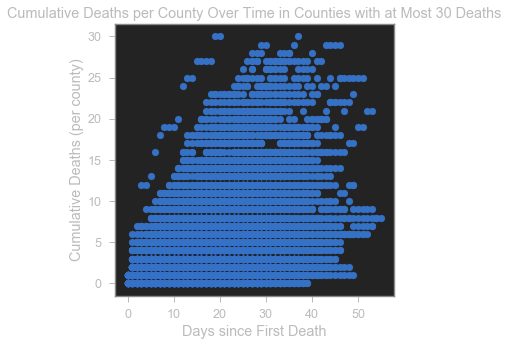

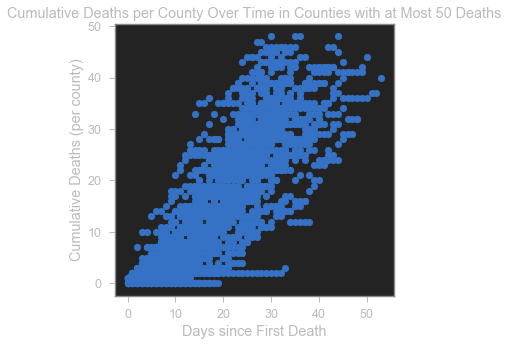

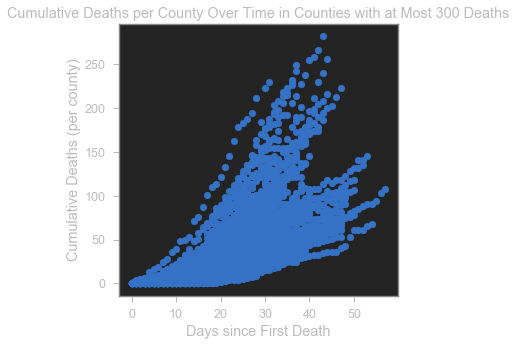

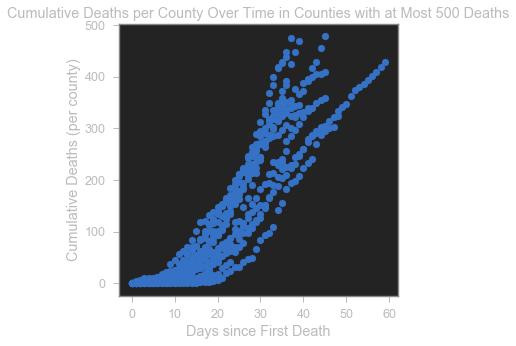

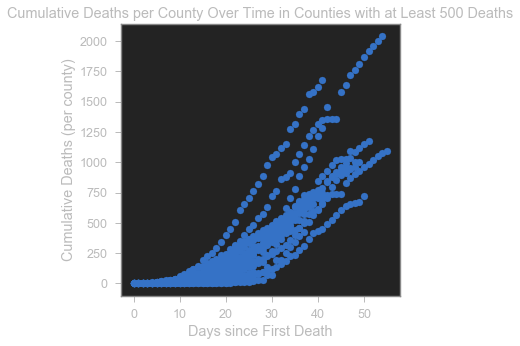

In [23]:
for i in range(len(divisions)):
    plt.figure(figsize=(5, 5))
    plt.scatter(divs_fitX[i], divs_fitY[i])
    plt.ylabel("Cumulative Deaths (per county)")
    plt.xlabel("Days since First Death")
    plt.title("Cumulative Deaths per County Over Time in Counties with at Most " + str(divisions[i]) + ' Deaths')
    plt.show()
plt.figure(figsize=(5, 5))
plt.scatter(divs_fitX[-1], divs_fitY[-1])
plt.ylabel("Cumulative Deaths (per county)")
plt.xlabel("Days since First Death")
plt.title("Cumulative Deaths per County Over Time in Counties with at Least " + str(divisions[-1]) + ' Deaths')
plt.show()

## Fitting and Predicting
### Now let's actually fit a logistic curve to each included county.

In [30]:
# import the sample submission for later use as a template to build our submission of predictions
sample_submission = pd.read_csv('../sample_submission.csv')
sample_submission.head()
len(sample_submission['id'])

293293

### First, we'll do a trial fitting on Snohomish County.

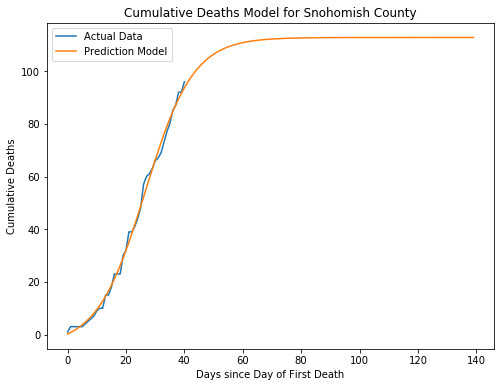

In [17]:
# package we'll use for fitting parameters
import scipy.optimize as opt

# logistic function with bias term
def f(x, L, b, k, x_0):
    return (L / (1 + np.exp(-k*(x - x_0)))) + b

# initialize randomized parameters
L, k = np.random.exponential(size=2)
b, x_0 = np.random.randn(2)

# prepare fit data, Snohomish FIPS is 53061
norm_scale = max(county_dict['53061'].deaths)
x = list(county_dict['53061'].times)
y = list(county_dict['53061'].deaths / norm_scale)

# fit function using Gauss-Newton Algorithm
(L_, b_, k_, x_0_), _ = opt.curve_fit(f, x, y, [L, b, k, x_0])
def fit_func(X): 
    return list([norm_scale * f(i, L_, b_, k_, x_0_)] for i in X) 

plt.figure(figsize=(8, 6))
plt.plot(x, (norm_scale * np.array(y)))
pred_range = list(range(0, max(x) + 100))
plt.plot(pred_range, fit_func(pred_range))
plt.title('Cumulative Deaths Model for Snohomish County')
plt.ylabel('Cumulative Deaths')
plt.xlabel('Days since Day of First Death')
plt.legend(['Actual Data', 'Prediction Model'])
plt.show()

### Now, let's formalize to build our predictions.

In [19]:
# returns the reference date (date of first death) of the inputted county
def get_ref_date(fips):
    counties = list(cum_deaths_df['fips'])
    deaths = list(cum_deaths_df['deaths'])
    dates = list(cum_deaths_df['date'])
    for i in range(len(counties)):
        if (counties[i] == fips and deaths[i] == 1):
            return dates[i]
    return '0'

# returns a modified dataframe (from df) with an added row for entry with id dcid and deaths per day dpd (t days from
# reference date)
def append_row(dcid, dpd, df, t):
    # remove previously 0 value predictions from template
    mod_df = df[df['id'] != dcid]
    
    # sample normal distribution centered at dpd with stdev of 1 dpd
    mean = float(dpd)
    stdev = 1.0
    num_samples = 1000
    dist = np.random.normal(mean, stdev, num_samples)
    
    # compute percentiles based on distribution
    percentiles = []
    for percentile in [10, 20, 30, 40, 50, 60, 70, 80, 90]:
        pval = np.percentile(dist, percentile)
        if pval < 0:
            pval = 0.0
        percentiles.append(pval)
    
    # add respective row to the dataframe and return the modified dataframe
    row = [dcid] + percentiles
    cols = list(df.columns)
    row_df = pd.DataFrame([row], columns=cols)
    return mod_df.append(row_df, ignore_index=True)
    
# contructs sumbission dataframe
def build_submission(template):
    preds = template.copy()
    verbose = 0
    for county in included_counties:
        verbose += 1
        print(str(100 * verbose / len(included_counties)) + '% complete')
        # prepare fit data for current county
        norm_scale = max(county_dict[county].deaths)
        x = list(county_dict[county].times)
        y = list(county_dict[county].deaths / norm_scale)
        
        try:
            # fit function using Gauss-Newton Algorithm
            (L_, b_, k_, x_0_), _ = opt.curve_fit(f, x, y, [L, b, k, x_0], maxfev=1000)
            def fit_func(X): 
                return list([norm_scale * f(i, L_, b_, k_, x_0_)] for i in X)

            # compute predictions 100 days into the future from the most recent date
            pred_range = list(range(0, max(x) + 100))
            cum_preds = fit_func(pred_range)

            # extract deaths per day predictions from cumulative predictions
            dpd_preds = []
            for i in range(0, len(cum_preds)):
                if i == 0:
                    dpd_preds.append(1)
                else:
                    dpd = cum_preds[i][0] - cum_preds[i - 1][0]  # (current day's death count) - (previous day's death count)
                    if dpd < 0:
                        dpd = 0
                    dpd_preds.append(dpd)

            # find ref_date and use it build list of <date-fips> IDs corresponding to predictions
            year, month, day = date_from_str(get_ref_date(county))
            ref_date = date(year, month, day)
            pred_ids = []
            for i in range(len(dpd_preds)):
                date_cur = ref_date + timedelta(days=i)
                pred_ids.append(str(date_cur.year) + '-' + str(date_cur.month) + '-' + str(date_cur.day)
                                 + '-' + county)

            # update dataframe with new predictions
            for i in range(len(pred_ids)):
                preds = append_row(pred_ids[i], dpd_preds[i], preds, i)
        except Exception:
            pass
    return preds

### We'll use the sample submission as a template.

In [20]:
sub_df = build_submission(sample_submission)
sub_df.head()

0.08019246190858059% complete
0.16038492381716118% complete
0.24057738572574178% complete


C:\Users\ethan\Miniconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


0.32076984763432237% complete
0.40096230954290296% complete
0.48115477145148355% complete
0.5613472333600642% complete
0.6415396952686447% complete
0.7217321571772254% complete
0.8019246190858059% complete
0.8821170809943866% complete
0.9623095429029671% complete
1.0425020048115476% complete
1.1226944667201284% complete
1.202886928628709% complete
1.2830793905372895% complete
1.36327185244587% complete
1.4434643143544508% complete
1.5236567762630313% complete
1.6038492381716118% complete
1.6840417000801924% complete
1.7642341619887731% complete
1.8444266238973537% complete
1.9246190858059342% complete
2.0048115477145148% complete
2.0850040096230953% complete
2.165196471531676% complete
2.245388933440257% complete
2.3255813953488373% complete
2.405773857257418% complete
2.4859663191659984% complete
2.566158781074579% complete
2.6463512429831595% complete
2.72654370489174% complete
2.8067361668003206% complete
2.8869286287089015% complete
2.967121090617482% complete
3.0473135525260626% c

23.496391339214114% complete
23.576583801122695% complete
23.656776263031276% complete
23.736968724939857% complete
23.817161186848438% complete
23.897353648757015% complete
23.977546110665596% complete
24.057738572574177% complete
24.137931034482758% complete
24.21812349639134% complete
24.29831595829992% complete
24.3785084202085% complete
24.458700882117082% complete
24.538893344025663% complete
24.619085805934244% complete
24.69927826784282% complete
24.779470729751402% complete
24.859663191659983% complete
24.939855653568564% complete
25.020048115477145% complete
25.100240577385726% complete
25.180433039294307% complete
25.260625501202888% complete
25.34081796311147% complete
25.421010425020047% complete
25.501202886928628% complete
25.58139534883721% complete
25.66158781074579% complete
25.74178027265437% complete
25.82197273456295% complete
25.902165196471532% complete
25.982357658380113% complete
26.062550120288694% complete
26.142742582197272% complete
26.222935044105853% comp

46.6720128307939% complete
46.752205292702484% complete
46.832397754611065% complete
46.912590216519646% complete
46.99278267842823% complete
47.07297514033681% complete
47.15316760224539% complete
47.23336006415397% complete
47.31355252606255% complete
47.39374498797113% complete
47.47393744987971% complete
47.554129911788294% complete
47.634322373696875% complete
47.714514835605456% complete
47.79470729751403% complete
47.87489975942261% complete
47.95509222133119% complete
48.03528468323977% complete
48.115477145148354% complete
48.195669607056935% complete
48.275862068965516% complete
48.3560545308741% complete
48.43624699278268% complete
48.51643945469126% complete
48.59663191659984% complete
48.67682437850842% complete
48.757016840417% complete
48.83720930232558% complete
48.917401764234164% complete
48.997594226142745% complete
49.077786688051326% complete
49.15797914995991% complete
49.23817161186849% complete
49.31836407377706% complete
49.39855653568564% complete
49.478748997

70.08821170809944% complete
70.16840417000802% complete
70.2485966319166% complete
70.32878909382518% complete
70.40898155573376% complete
70.48917401764234% complete
70.56936647955092% complete
70.6495589414595% complete
70.72975140336808% complete
70.80994386527667% complete
70.89013632718525% complete
70.97032878909383% complete
71.05052125100241% complete
71.13071371291099% complete
71.21090617481957% complete
71.29109863672815% complete
71.37129109863673% complete
71.45148356054531% complete
71.5316760224539% complete
71.61186848436247% complete
71.69206094627106% complete
71.77225340817964% complete
71.85244587008822% complete
71.9326383319968% complete
72.01283079390538% complete
72.09302325581395% complete
72.17321571772253% complete
72.25340817963111% complete
72.33360064153969% complete
72.41379310344827% complete
72.49398556535685% complete
72.57417802726543% complete
72.65437048917401% complete
72.7345629510826% complete
72.81475541299118% complete
72.89494787489976% comple

93.74498797113071% complete
93.82518043303929% complete
93.90537289494787% complete
93.98556535685645% complete
94.06575781876504% complete
94.14595028067362% complete
94.2261427425822% complete
94.30633520449078% complete
94.38652766639936% complete
94.46672012830794% complete
94.54691259021652% complete
94.6271050521251% complete
94.70729751403368% complete
94.78748997594226% complete
94.86768243785085% complete
94.94787489975943% complete
95.02806736166801% complete
95.10825982357659% complete
95.18845228548517% complete
95.26864474739375% complete
95.34883720930233% complete
95.42902967121091% complete
95.5092221331195% complete
95.58941459502806% complete
95.66960705693664% complete
95.74979951884522% complete
95.8299919807538% complete
95.91018444266238% complete
95.99037690457097% complete
96.07056936647955% complete
96.15076182838813% complete
96.23095429029671% complete
96.31114675220529% complete
96.39133921411387% complete
96.47153167602245% complete
96.55172413793103% compl

,id,10,20,30,40,50,60,70,80,90
0,2020-04-01-10001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-04-01-10003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-04-01-10005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-04-01-1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-04-01-1003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
sub_df.tail()

,id,10,20,30,40,50,60,70,80,90
404739,2020-7-24-6073,0.0,0.0,0.0,0.0,0.000000,0.261475,0.515572,0.758030,1.269320
404740,2020-7-25-6073,0.0,0.0,0.0,0.0,0.040683,0.299855,0.564651,0.851680,1.313788
404741,2020-7-26-6073,0.0,0.0,0.0,0.0,0.029041,0.255480,0.514992,0.860929,1.267911
404742,2020-7-27-6073,0.0,0.0,0.0,0.0,0.011027,0.303817,0.564524,0.858461,1.278859
404743,2020-7-28-6073,0.0,0.0,0.0,0.0,0.000000,0.268566,0.522298,0.838154,1.272936


### We need to make sure the submission is valid and evaluate its predictions. This code is from the provided file evaluator.py

In [21]:
import sys
import traceback
from tqdm.auto import tqdm

csv_to_score = '../sample_submission.csv'

def get_date(x):
    return '-'.join(x.split('-')[:3])
def get_fips(x):
    return x.split('-')[-1]
def pinball_loss(y_true, y_pred, quantile = 0.5):
    delta = y_true - y_pred
    loss_above = np.sum(delta[delta > 0])*(quantile)
    loss_below = np.sum(-1*delta[delta < 0])*(1-quantile)
    return (loss_above + loss_below) / len(y_true)
def evaluate(test_df, user_df):
    join_df = test_df.join(user_df, how = 'inner')
    if(len(join_df) != len(test_df)):
        sys.stderr.write("Submission not right length. \n")
        raise Exception("Submission not right length")
    if(user_df.isna().sum().sum() > 0 ):
        sys.stderr.write("Submission contains NaN. \n")
        raise Exception("Submission Contains NaN.")
    if(join_df.index.equals(test_df.index) == False):
        sys.stderr.write("Incorrect ID format in Submission. \n")
        raise Exception("Incorrect ID format.")
    total_loss = 0
    for column in ['10','20','30','40','50', '60', '70', '80', '90']:
        quantile = int(column) / 100.0
        total_loss += pinball_loss(join_df['deaths'].values, join_df[column].values, quantile) / 9.0
    return total_loss

start_date = '2020-04-17' # First date to include in scoring
daily_df = pd.read_csv('../data/us/covid/nyt_us_counties_daily.csv') # Daily data processed from NYT.
end_date = daily_df['date'].max() # End with the most recent date.

daily_df = daily_df[(daily_df['date'] <= end_date)  & (daily_df['date'] >= start_date)] # Select correct date range.
daily_df['id'] = daily_df['date'] +'-'+ daily_df['fips'].astype(str) # Create id column

sample_submission = pd.read_csv('../sample_submission.csv') # Load the sample submission with all 0's
sample_submission['date'] = sample_submission['id'].apply(get_date)
sample_submission['fips'] = sample_submission['id'].apply(get_fips).astype('int')
sample_submission = sample_submission[(sample_submission['date'] <= end_date)  & (sample_submission['date'] >= start_date)]

# Disabled FIPS is a set of FIPS to avoid scoring. Covid_active_fips is where there has been reports of covid, 
# and inactive_fips are fips codes present in sample submission but with no cases reported by the New York Times.
# Active FIPS should be scored against deaths data from NYT if such data is available, 
# but Inactive FIPS should be scored with a target of 0.
disabled_fips = {'36061'}
covid_active_fips = set(daily_df.fips.unique()).intersection(set(sample_submission.fips.unique())) - disabled_fips
inactive_fips = set(sample_submission.fips.unique()) - set(daily_df.fips.unique()) - disabled_fips

# Create a DataFrame of all 0's for inactive fips by getting those from sample submission.
inactive_df = sample_submission.set_index('fips')[['id','50']].loc[inactive_fips]
inactive_df = inactive_df.set_index('id').rename({'50':'deaths'}, axis = 1)
assert(inactive_df.sum().sum() == 0) 
# Create a DataFrame of active fips from the New York Times data
active_df = daily_df.set_index('fips')[['id', 'deaths']].loc[covid_active_fips].set_index('id')

# Join the data frames
example = pd.concat([inactive_df, active_df]).sort_index()

# Read some CSV for score
# df = pd.read_csv(csv_to_score).set_index('id').sort_index()
df = sub_df.copy()
score = evaluate(example[['deaths']], df)
print('Got score of {:.6f}'.format(score))

Submission not right length. 


Exception: Submission not right length

In [31]:
sub_df.to_csv('submission1_billy_kimba.csv')

In [33]:
ids = list(sub_df['id'])
corrected_ids = []
for iD in ids:
    if (iD[7] != '-'):
        corrected_ids.append(iD[:5] + '0' + iD[5:])
    if (iD[10] != '-'):
        corrected_ids.append(iD[:8] + '0' + iD[8:])
    else:
        corrected_ids.append(iD)
print(corrected_ids)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

